In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.visualization.plots import plot_score_differences_vars
from src.data.tidy_data import prepare_data, create_pivot_table
from src.results.statistical_analysis import calculate_grouped_statistics, evaluate_differences, generate_difference_report, perform_post_hoc_analysis, identify_significant_differences
import warnings
warnings.filterwarnings('ignore')

In [41]:
df_score_differences = pd.read_parquet('data/results/score_differences_data.parquet')
df_performance_results = pd.read_parquet('data/results/performance_data.parquet')
df_description = pd.read_parquet('data/results/df_description_data.parquet')

In [42]:
df_score_differences

,dataset,metric_x,score,score_sd,k,metric_y,dataset_complexity,minority_class_complexity,most_complex_class,diff_score_minority_class_complexity,diff_score_most_complex_class,diff_score_dataset
0,a9a,accuracy_score,0.850035,0.003225,1,kdn,0.188784,0.375717,0.375717,0.225753,0.225753,0.038820
1,a9a,accuracy_score,0.850035,0.003225,1,ddn,0.212416,0.423633,0.423633,0.273669,0.273669,0.062451
2,a9a,accuracy_score,0.850035,0.003225,2,kdn,0.200163,0.394082,0.394082,0.244118,0.244118,0.050198
3,a9a,accuracy_score,0.850035,0.003225,2,ddn,0.214395,0.427657,0.427657,0.277693,0.277693,0.064431
4,a9a,accuracy_score,0.850035,0.003225,3,kdn,0.204375,0.405816,0.405816,0.255851,0.255851,0.054411
...,...,...,...,...,...,...,...,...,...,...,...,...
5491,vehicle2,scaled_mcc_score,0.987671,0.007849,8,ddn,0.154563,0.269450,0.269450,0.257120,0.257120,0.142233
5492,vehicle2,scaled_mcc_score,0.987671,0.007849,9,kdn,0.074205,0.113660,0.113660,0.101330,0.101330,0.061876
5493,vehicle2,scaled_mcc_score,0.987671,0.007849,9,ddn,0.166891,0.290963,0.290963,0.278634,0.278634,0.154562
5494,vehicle2,scaled_mcc_score,0.987671,0.007849,10,kdn,0.079078,0.120642,0.120642,0.108313,0.108313,0.066749


In [43]:
mask_acc = ((df_score_differences['metric_x'] == 'accuracy_score') & (((df_score_differences['metric_y'] == 'kdn') & (df_score_differences['k'] == 1)) | 
                                                                      ((df_score_differences['metric_y'] == 'ddn') & (df_score_differences['k'] == 1))))
mask_f1 = ((df_score_differences['metric_x'] == 'f1_score') & (((df_score_differences['metric_y'] == 'kdn') & (df_score_differences['k'] == 7)) | 
                                                                      ((df_score_differences['metric_y'] == 'ddn') & (df_score_differences['k'] == 1))))
mask_gps = ((df_score_differences['metric_x'] == 'gps_score') & (((df_score_differences['metric_y'] == 'kdn') & (df_score_differences['k'] == 7)) | 
                                                                      ((df_score_differences['metric_y'] == 'ddn') & (df_score_differences['k'] == 1))))
mask_mcc = ((df_score_differences['metric_x'] == 'scaled_mcc_score') & (((df_score_differences['metric_y'] == 'kdn') & (df_score_differences['k'] == 3)) | 
                                                                      ((df_score_differences['metric_y'] == 'ddn') & (df_score_differences['k'] == 1))))


df_score_differences_best_complexity = df_score_differences[mask_acc+mask_f1+mask_gps+mask_mcc]

In [44]:
df_merged = prepare_data(df_description, df_score_differences_best_complexity, df_performance_results, None)

In [45]:
df_merged

,dataset,metric_x,score,score_sd,k,metric_y,dataset_complexity,minority_class_complexity,most_complex_class,diff_score_minority_class_complexity,diff_score_most_complex_class,diff_score_dataset,class_prop_category,class_prop,best_method,minority_class_complexity_category,most_complex_class_category
0,a9a,accuracy_score,0.850035,0.003225,1,kdn,0.188784,0.375717,0.375717,0.225753,0.225753,0.038820,0.2-0.3,0.241,GradientBoostingClassifier,0.3-0.4,0.3-0.4
1,a9a,accuracy_score,0.850035,0.003225,1,ddn,0.212416,0.423633,0.423633,0.273669,0.273669,0.062451,0.2-0.3,0.241,GradientBoostingClassifier,0.4-0.5,0.4-0.5
2,appendicitis,accuracy_score,0.887013,0.056549,1,kdn,0.188679,0.380952,0.380952,0.267965,0.267965,0.075692,0.1-0.2,0.198,SVC,0.3-0.4,0.3-0.4
3,appendicitis,accuracy_score,0.887013,0.056549,1,ddn,0.188679,0.380952,0.380952,0.267965,0.267965,0.075692,0.1-0.2,0.198,SVC,0.3-0.4,0.3-0.4
4,australian,accuracy_score,0.875362,0.037345,1,kdn,0.201449,0.234528,0.234528,0.109890,0.109890,0.076812,0.4-0.5,0.445,GradientBoostingClassifier,0.2-0.3,0.2-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,glass1,scaled_mcc_score,0.809645,0.069831,3,kdn,0.225857,0.350877,0.350877,0.160523,0.160523,0.035502,0.3-0.4,0.355,GradientBoostingClassifier,0.3-0.4,0.3-0.4
516,newthyroid2,scaled_mcc_score,0.984466,0.019025,1,ddn,0.013953,0.028571,0.028571,0.013038,0.013038,-0.001580,0.1-0.2,0.163,KNeighborsClassifier,0-0.1,0-0.1
517,newthyroid2,scaled_mcc_score,0.984466,0.019025,3,kdn,0.027907,0.123810,0.123810,0.108276,0.108276,0.012373,0.1-0.2,0.163,KNeighborsClassifier,0.1-0.2,0.1-0.2
518,vehicle2,scaled_mcc_score,0.987671,0.007849,1,ddn,0.026005,0.036697,0.036697,0.024368,0.024368,0.013675,0.2-0.3,0.258,GradientBoostingClassifier,0-0.1,0-0.1


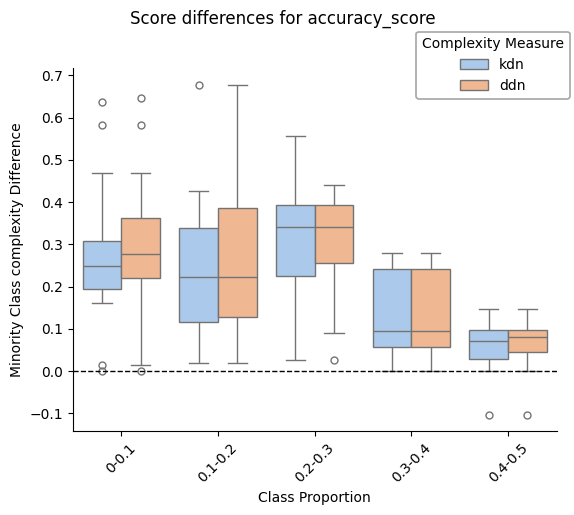

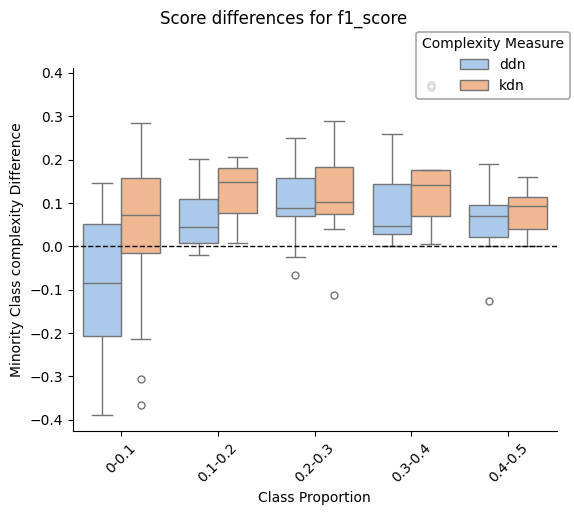

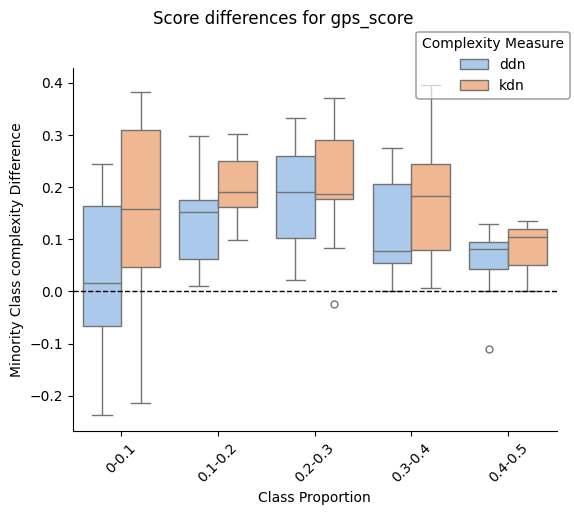

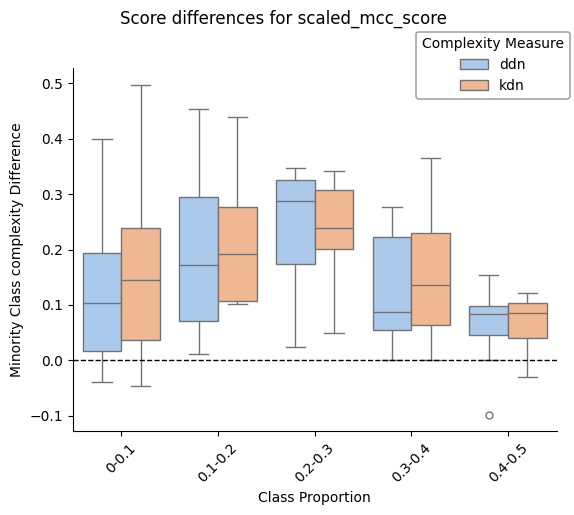

In [34]:
plot_score_differences_vars(df_merged, diff='diff_score_minority_class_complexity', x_var='class_prop_category')

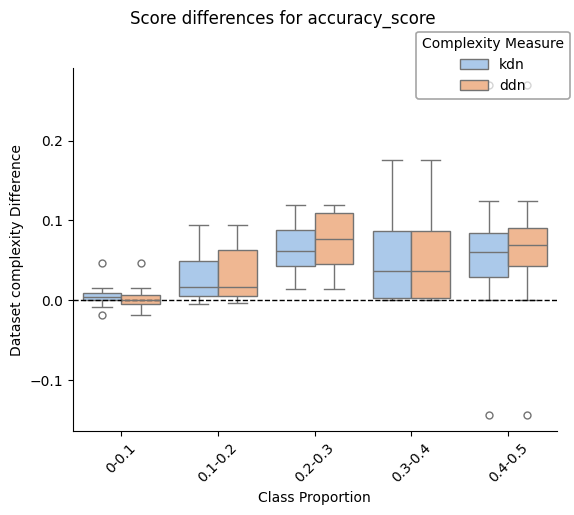

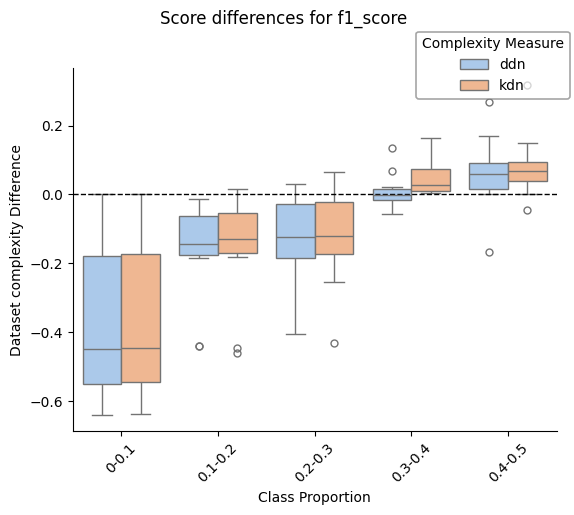

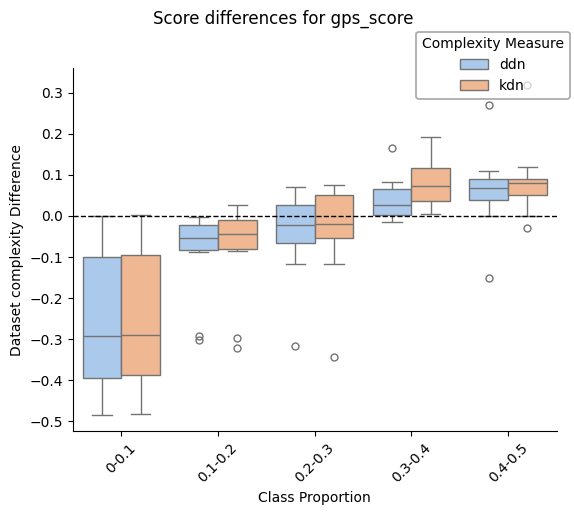

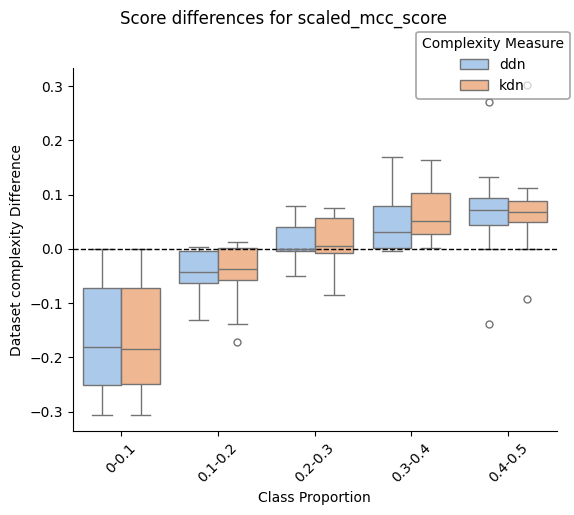

In [27]:
plot_score_differences_vars(df_merged, diff='diff_score_dataset', x_var='class_prop_category', y_title='Dataset complexity Difference')

In [28]:
calculate_grouped_statistics(df_merged[df_merged['metric_x'] == 'accuracy_score'], diff='diff_score_dataset', x_var='class_prop_category')

,class_prop_category,metric_y,median,mean,std,min,max,count
0,0-0.1,ddn,5.551115e-17,0.003063,0.013200,-0.019024,0.046812,20
1,0-0.1,kdn,4.160300e-03,0.004907,0.012563,-0.019024,0.046812,20
2,0.1-0.2,ddn,1.610940e-02,0.032911,0.035339,-0.003999,0.094444,10
3,0.1-0.2,kdn,1.610940e-02,0.030875,0.033652,-0.005118,0.094444,10
4,0.2-0.3,ddn,7.662081e-02,0.072882,0.036026,0.014693,0.119385,13
5,0.2-0.3,kdn,6.133399e-02,0.066376,0.035825,0.014693,0.119385,13
6,0.3-0.4,ddn,3.730819e-02,0.055453,0.060210,0.000000,0.175476,10
7,0.3-0.4,kdn,3.730819e-02,0.054969,0.059745,-0.000084,0.175476,10
8,0.4-0.5,ddn,6.962118e-02,0.064823,0.095093,-0.143525,0.270000,12
9,0.4-0.5,kdn,6.081215e-02,0.060644,0.095109,-0.143525,0.270000,12


In [24]:
calculate_grouped_statistics(df_merged[df_merged['metric_x'] == 'f1_score'], diff='diff_score_minority_class_complexity', x_var='class_prop_category')

,class_prop_category,metric_y,median,mean,std,min,max,count
0,0-0.1,ddn,-0.083692,-0.089064,0.171930,-0.388638,0.145113,20
1,0-0.1,kdn,0.073176,0.034870,0.182158,-0.365681,0.284211,20
2,0.1-0.2,ddn,0.044633,0.065205,0.071037,-0.019960,0.200952,10
3,0.1-0.2,kdn,0.148217,0.127813,0.067571,0.007125,0.205034,10
4,0.2-0.3,ddn,0.088771,0.099677,0.094114,-0.066053,0.250549,13
5,0.2-0.3,kdn,0.102807,0.115824,0.099387,-0.112626,0.288285,13
6,0.3-0.4,ddn,0.046442,0.089107,0.085997,0.000000,0.259240,10
7,0.3-0.4,kdn,0.140907,0.155623,0.127494,0.006515,0.372619,10
8,0.4-0.5,ddn,0.069926,0.057059,0.077686,-0.126820,0.190319,12
9,0.4-0.5,kdn,0.091956,0.081655,0.051729,0.000000,0.160733,12


In [25]:
calculate_grouped_statistics(df_merged[df_merged['metric_x'] == 'gps_score'], diff='diff_score_minority_class_complexity', x_var='class_prop_category')

,class_prop_category,metric_y,median,mean,std,min,max,count
0,0-0.1,ddn,0.016752,0.025135,0.149084,-2.366628e-01,0.243747,20
1,0-0.1,kdn,0.158832,0.149069,0.173176,-2.137062e-01,0.382212,20
2,0.1-0.2,ddn,0.152900,0.140349,0.100624,1.108073e-02,0.297534,10
3,0.1-0.2,kdn,0.191222,0.202957,0.065194,9.937478e-02,0.301616,10
4,0.2-0.3,ddn,0.189780,0.185847,0.104949,2.181169e-02,0.333158,13
5,0.2-0.3,kdn,0.186848,0.201994,0.101573,-2.476135e-02,0.370894,13
6,0.3-0.4,ddn,0.077413,0.118906,0.096189,-2.626488e-11,0.274523,10
7,0.3-0.4,kdn,0.182381,0.185422,0.135965,6.514658e-03,0.396344,10
8,0.4-0.5,ddn,0.081027,0.059322,0.067821,-1.108512e-01,0.130090,12
9,0.4-0.5,kdn,0.103807,0.083918,0.048058,-2.573786e-11,0.135451,12


In [27]:
calculate_grouped_statistics(df_merged[df_merged['metric_x'] == 'scaled_mcc_score'], diff='diff_score_minority_class_complexity', x_var='class_prop_category')

,class_prop_category,metric_y,median,mean,std,min,max,count
0,0-0.1,ddn,0.104422,0.120363,0.128896,-0.038468,0.398407,20
1,0-0.1,kdn,0.144972,0.164475,0.148365,-0.046259,0.496926,20
2,0.1-0.2,ddn,0.172676,0.184921,0.148558,0.012127,0.452507,10
3,0.1-0.2,kdn,0.191715,0.213611,0.117356,0.101135,0.439174,10
4,0.2-0.3,ddn,0.287359,0.238033,0.102406,0.024368,0.346336,13
5,0.2-0.3,kdn,0.238410,0.242082,0.084013,0.048833,0.341619,13
6,0.3-0.4,ddn,0.087907,0.125610,0.099681,0.000000,0.276418,10
7,0.3-0.4,kdn,0.135275,0.160622,0.126144,0.001086,0.364334,10
8,0.4-0.5,ddn,0.082952,0.064834,0.068287,-0.098006,0.154301,12
9,0.4-0.5,kdn,0.084772,0.067979,0.051375,-0.029277,0.120771,12


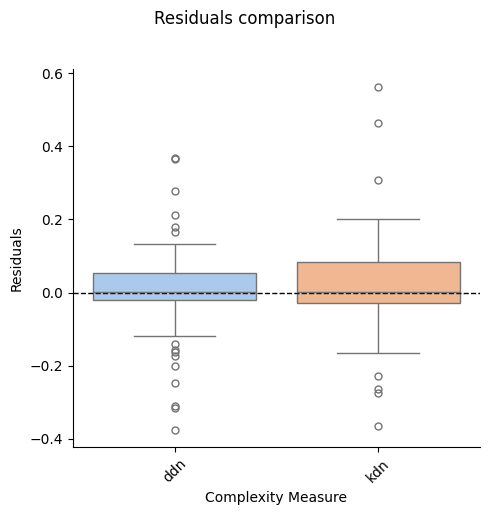

Resumen estadístico de los residuos por grupo:
          count  mean   std   min   10%   20%   30%  40%  50%   60%   70%  \
metric_y                                                                    
ddn        78.0  0.00  0.12 -0.38 -0.15 -0.05 -0.00 -0.0  0.0  0.01  0.03   
kdn        78.0  0.02  0.14 -0.36 -0.14 -0.05 -0.02 -0.0  0.0  0.02  0.06   

           80%   90%   max  
metric_y                    
ddn       0.08  0.13  0.37  
kdn       0.10  0.15  0.56  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Función para entrenar y evaluar el modelo para un subconjunto de datos
def train_and_evaluate_model(data, label):
    # Seleccionar las variables predictoras y la variable respuesta
    X = data[["dataset_complexity", "minority_class_complexity"]]
    y = data["score"]
    
    # Dividir los datos en entrenamiento (70%) y test (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=data['metric_x'], random_state=42)
    
    # Crear y entrenar el árbol de regresión
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Predicción en el conjunto de test
    y_pred = model.predict(X_test)
    
    return model, X_test, y_test, y_pred

# Filtrar el dataset para cada grupo
datos_ddn = df_merged[df_merged['metric_y'] == 'ddn'].copy()
datos_kdn = df_merged[df_merged['metric_y'] == 'kdn'].copy()

# Entrenar y evaluar el modelo para ddn y kdn
model_ddn, X_test_ddn, y_test_ddn, y_pred_ddn = train_and_evaluate_model(datos_ddn, 'ddn')
model_kdn, X_test_kdn, y_test_kdn, y_pred_kdn = train_and_evaluate_model(datos_kdn, 'kdn')

# Calcular los residuos para cada modelo
resid_ddn = y_test_ddn - y_pred_ddn
resid_kdn = y_test_kdn - y_pred_kdn

# Crear DataFrames para los residuos de cada grupo y unirlos
df_resid_ddn = pd.DataFrame({"resid": resid_ddn, "metric_y": "ddn"})
df_resid_kdn = pd.DataFrame({"resid": resid_kdn, "metric_y": "kdn"})
df_resid = pd.concat([df_resid_ddn, df_resid_kdn], ignore_index=True)

# --- Gráfico 1: Boxplot comparativo de residuos con Seaborn ---
g = sns.catplot(
    data=df_resid,
    x="metric_y",
    y="resid",
    kind="box",
    palette="pastel",
    legend_out=True
)
g.fig.suptitle("Residuals comparison", y=1.02)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel("Residuals")
plt.xlabel("Complexity Measure")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Obtener los colores de la paleta "pastel" para usar en los gráficos diagnósticos
colors = sns.color_palette("pastel", 2)
color_ddn = colors[0]
color_kdn = colors[1]

# --- Resumen estadístico de los residuos ---
print("Resumen estadístico de los residuos por grupo:")
print(df_resid.groupby("metric_y")["resid"].describe(percentiles=[i*0.1 for i in range(1,10)]).round(2))
